In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
import sklearn.impute
import sklearn.linear_model
import sklearn.metrics
import sklearn.model_selection

In [2]:
def ecdf(data):
    plt.plot(np.sort(data), np.linspace(0,1,len(data)))

In [3]:
train_o = pd.read_csv("data/train.csv")
test_o = pd.read_csv("data/test.csv")

In [4]:
filler = sklearn.impute.SimpleImputer(strategy="mean", fill_value=0)

train_fill = filler.fit_transform(train_o.iloc[:,1:])
test_fill = filler.fit_transform(test_o.iloc[:,1:])

In [5]:
trainX, valX, trainY, valY = sklearn.model_selection.train_test_split(train_fill[:,:-1], train_fill[:,-1])

0.6451285852809252

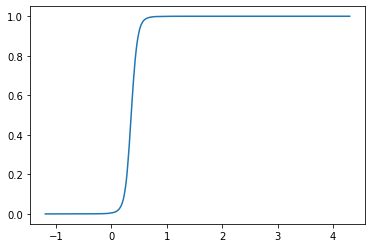

In [6]:
ridge = sklearn.linear_model.Ridge()
ridge.fit(trainX, trainY)
p = ridge.predict(valX)
ecdf(p)
sklearn.metrics.roc_auc_score(valY, p)

In [7]:
ridge = sklearn.linear_model.Ridge()
ridge.fit(train_fill[:,:-1], train_fill[:,-1])
p = ridge.predict(test_fill)

In [14]:
pscale = (p - np.min(p)) / (np.max(p)-np.min(p))

In [17]:
out = pd.DataFrame({"id":test_o.iloc[:,0], "Predicted":pscale})

In [18]:
with open("stockrdige.csv", "w") as f:
    f.write(out.to_csv(index=False))

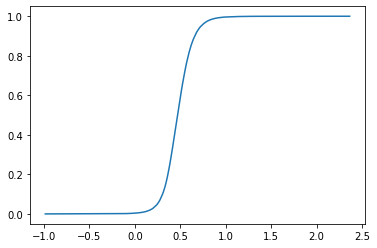

In [10]:
ecdf(p)

In [16]:
print(min(pscale),max(pscale))

0.0 1.0
